In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

dataset

In [19]:
data = pd.read_csv("customer.csv")

Explore dataset

In [20]:
data.head()

,customer_id,monetary_purchase_amt,frequency_purchase,recency_of_purchase
0,1,3.097321,18.795885,15.108402
1,2,8.759256,21.893389,13.801586
2,3,16.634326,4.270323,23.046506
3,4,10.934102,22.335917,15.445987
4,5,13.832831,22.255416,16.896821


In [21]:
data.describe()

,customer_id,monetary_purchase_amt,frequency_purchase,recency_of_purchase
count,300.000000,300.000000,300.000000,300.000000
mean,150.500000,11.246826,12.693658,13.343224
std,86.746758,5.160173,8.332946,6.105275
min,1.000000,1.000000,1.000000,1.000000
25%,75.750000,7.044447,4.480629,9.334245
50%,150.500000,12.571806,12.836128,14.369357
75%,225.250000,15.637317,20.965817,18.259287
max,300.000000,19.283131,23.550300,23.046506


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            300 non-null    int64  
 1   monetary_purchase_amt  300 non-null    float64
 2   frequency_purchase     300 non-null    float64
 3   recency_of_purchase    300 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 9.5 KB


The dataset is clean

In this dataset we have RFM columns so we do this:

In [24]:
rfm = data[['monetary_purchase_amt','frequency_purchase','recency_of_purchase']]
rfm

,monetary_purchase_amt,frequency_purchase,recency_of_purchase
0,3.097321,18.795885,15.108402
1,8.759256,21.893389,13.801586
2,16.634326,4.270323,23.046506
3,10.934102,22.335917,15.445987
4,13.832831,22.255416,16.896821
...,...,...,...
295,5.403240,20.929441,14.415232
296,15.094120,3.687939,19.239145
297,8.902355,20.969222,16.440854
298,5.174094,20.532672,12.106431


In [25]:
rfm.describe()

,monetary_purchase_amt,frequency_purchase,recency_of_purchase
count,300.000000,300.000000,300.000000
mean,11.246826,12.693658,13.343224
std,5.160173,8.332946,6.105275
min,1.000000,1.000000,1.000000
25%,7.044447,4.480629,9.334245
50%,12.571806,12.836128,14.369357
75%,15.637317,20.965817,18.259287
max,19.283131,23.550300,23.046506


Now we scale rfm onto 1-5

In [28]:
recency_bins = [rfm['recency_of_purchase'].min()-1, 10, 15, 18, 20, rfm['recency_of_purchase'].max()]
frequency_bins = [rfm['frequency_purchase'].min() - 1, 5, 10, 20, 23, rfm['frequency_purchase'].max()]
monetary_bins = [rfm['monetary_purchase_amt'].min() - 1,5 , 12, 15, 18, rfm['monetary_purchase_amt'].max()]

rfm['R_Score'] = pd.cut(rfm['recency_of_purchase'], bins=recency_bins, labels=range(1, 6), include_lowest=True)

# Reverse the Recency scores so that higher values indicate more recent purchases
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1

# Calculate Frequency and Monetary scores based on custom bins
rfm['F_Score'] = pd.cut(rfm['frequency_purchase'], bins=frequency_bins, labels=range(1, 6), include_lowest=True).astype(int)
rfm['M_Score'] = pd.cut(rfm['monetary_purchase_amt'], bins=monetary_bins, labels=range(1, 6), include_lowest=True).astype(int)

In [29]:
print(rfm[['R_Score', 'F_Score', 'M_Score']].head(10))

   R_Score  F_Score  M_Score
0        3        3        1
1        4        4        2
2        1        1        4
3        3        4        2
4        3        4        3
5        3        4        2
6        5        2        3
7        4        4        2
8        5        2        3
9        4        4        2


Now we perform k-means clustring

In [30]:
X = rfm[['R_Score', 'F_Score', 'M_Score']]

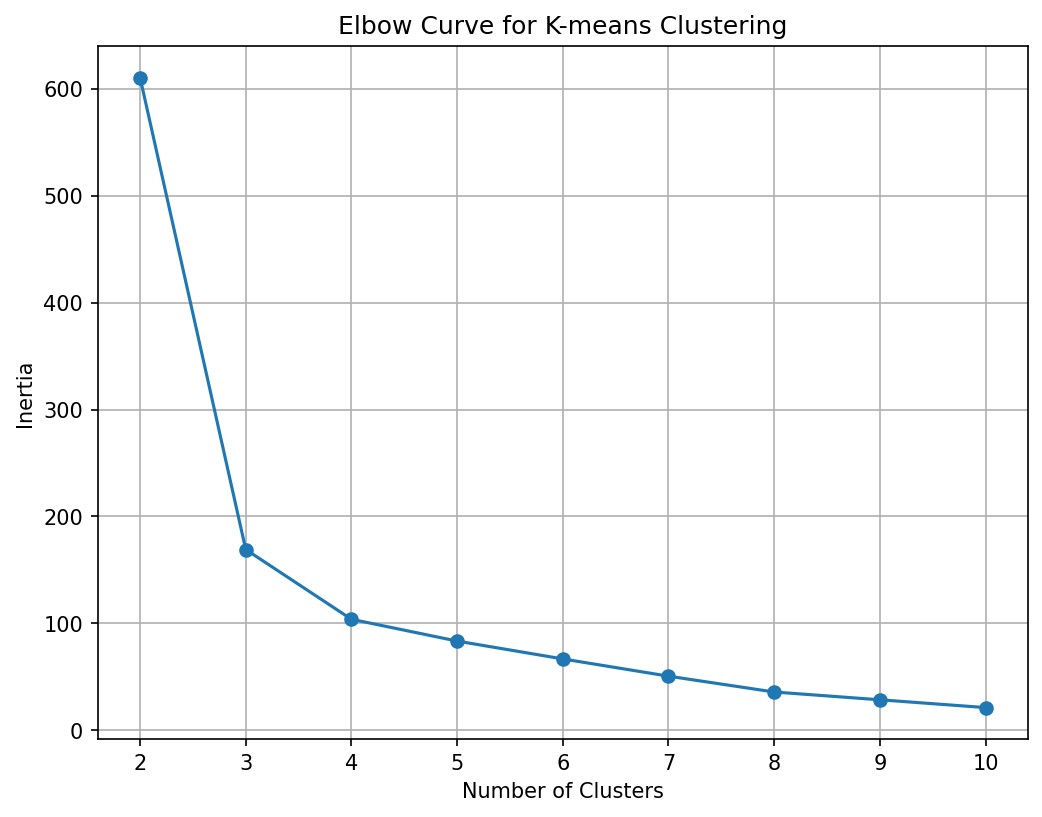

In [33]:



inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

as it shows We have 4 clusters.

In [35]:
# Perform K-means clustering 
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

Now we got clusters so we can divide customers like this:

In [37]:
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()

print(cluster_summary)

   Cluster   R_Score   F_Score   M_Score
0        0  5.000000  1.813333  3.333333
1        1  1.266667  1.026667  4.120000
2        2  3.317647  4.035294  2.011765
3        3  3.984615  3.430769  1.030769


now  let’s visualize the average R, F, and M scores for the clusters 

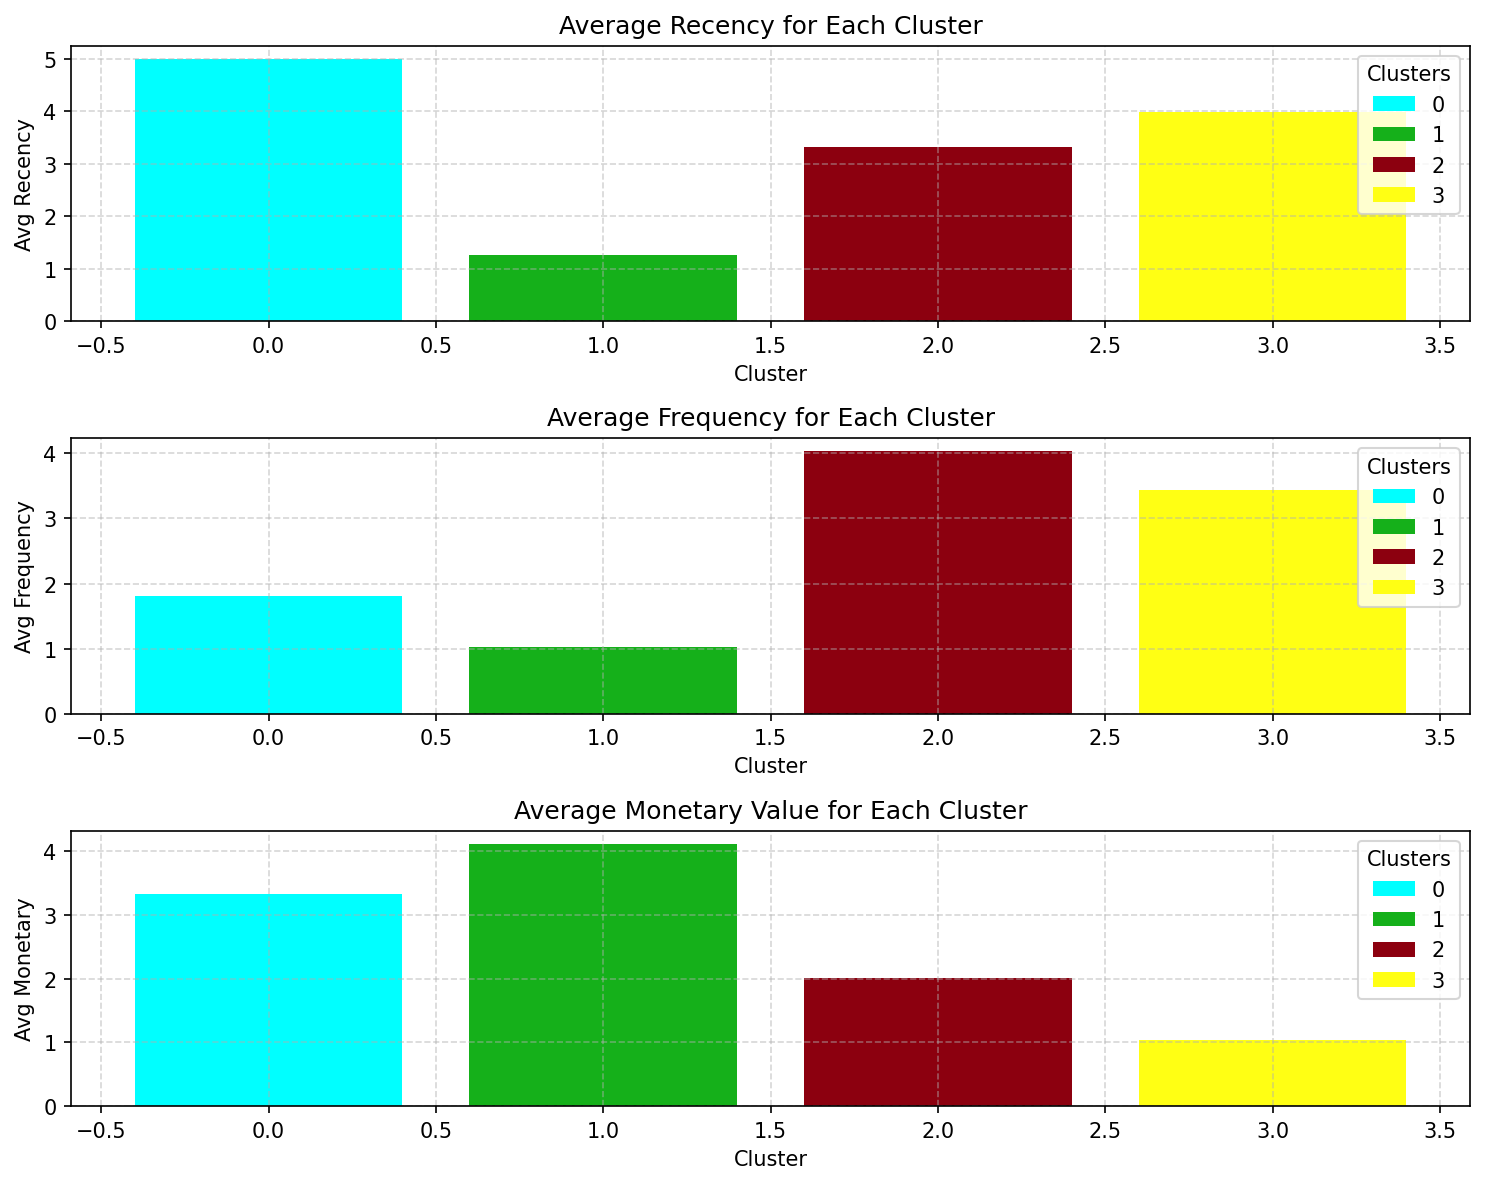

In [40]:
colors = ['#00FFFF', '#15B01A', '#8C000F','#FFFF14']


plt.figure(figsize=(10, 8),dpi=150)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary Value for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()

As a result:

Cluster 0: Of all the four clusters, this cluster has the highest recency, frequency, and monetary values. Let’s call the customers in this cluster power shoppers.

Cluster 1: This cluster is characterized by moderate recency, frequency, and monetary values. These customers still spend more and purchase more frequently than clusters 2 and 3. Let’s call them loyal customers.

Cluster 2: Customers in this cluster tend to spend less. They don’t buy often, and haven’t made a purchase recently either. These are likely inactive.

Cluster 3: This cluster is characterized by high recency and relatively lower frequency and moderate monetary values. So these are recent customers who can potentially become long-term customers.

Now Let’s visualize the distribution of the different clusters

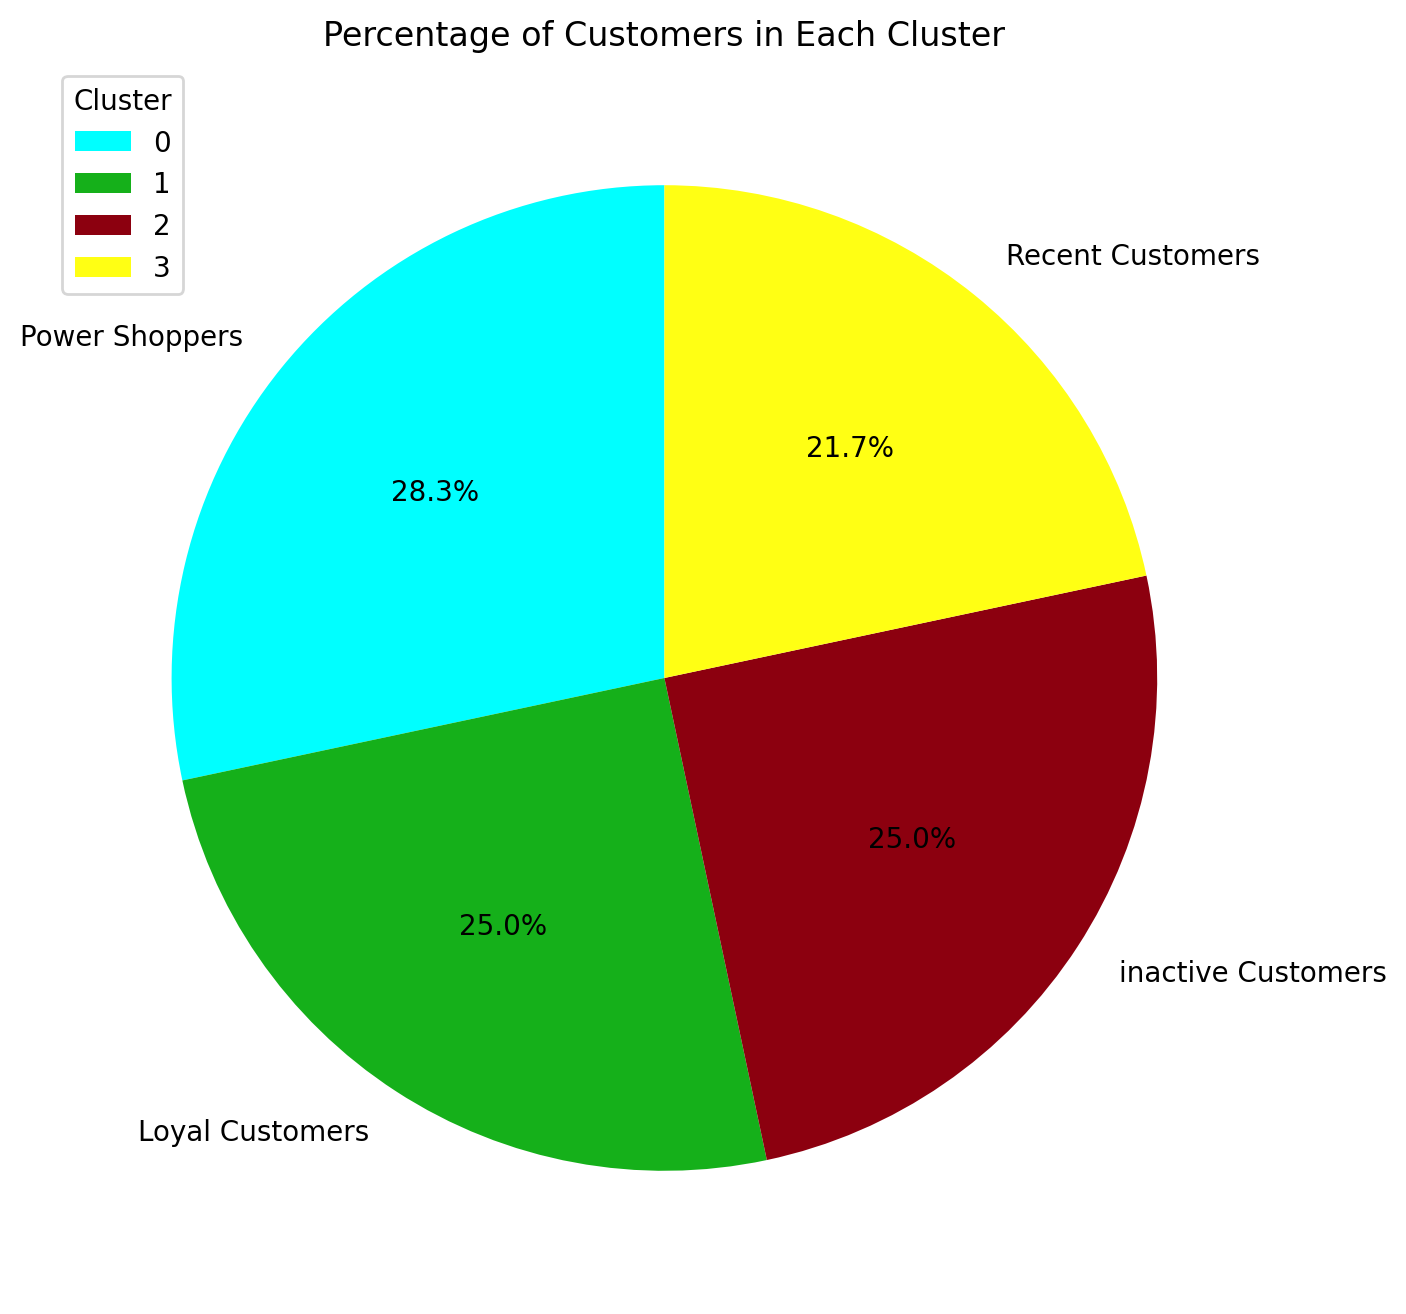

In [43]:
cluster_counts = rfm['Cluster'].value_counts()

colors = ['#00FFFF', '#15B01A', '#8C000F','#FFFF14']
# Calculate the total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
percentage_customers = (cluster_counts / total_customers) * 100

labels = ['Power Shoppers','Loyal Customers','inactive Customers','Recent Customers']

# Create a pie chart
plt.figure(figsize=(8, 8),dpi=200)
plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Customers in Each Cluster')
plt.legend(cluster_summary['Cluster'], title='Cluster', loc='upper left')

plt.show()